<a href="https://colab.research.google.com/github/realsanjeev/Image-Captioning-using-Attention-Mechanism/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries
**This notebook only RUNS for specific version of tensorflow==2.8.1 as new updates contains breaking changes**

**Note** `cupy` is `Numpy` equivalent for GPU. Read [Official Website - cupy.dev](https://cupy.dev/)

In [7]:
!pip install tf-keras~=2.16 -q
!pip install tensorflow -U -q
!pip install numpy -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 60.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.1 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.1 which is incompatible.
pandas 2.1.4 requires numpy<2,>=1.22.4; python_version < "3.11", but you have numpy 2.1.1 which is incompatible.
pytensor 2.25.4 requires numpy<2,>=1.17.0, but you have numpy 2.1.1 which is incompatible.
rmm-cu12 24.4.0 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.1 which is incompatible.
t

In [8]:
import os

os.environ["TF_USE_LEGACY_KERAS"]="1"

In [9]:
import sys
import time
import os
import warnings

# for doing operation in gpu
import numpy as np
# for working in gpu numpy equivalent
# import cupy

from collections import Counter
from tensorflow.python.keras.backend import set_session
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

In [10]:
import tensorflow as tf
import keras
from keras.layers import (TextVectorization)

import tensorflow_datasets as tfds

In [15]:
print(f"python {sys.version}")
print(f"Numpy version: {np.__version__}")
# print(f"cupy version: {np.__version__}")
print(f"keras version: {keras.__version__}");
print(f"tensorflow version: {tf.__version__}")
print(f"tensorflow datasets version: {tfds.__version__}")

python 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Numpy version: 1.26.4
keras version: 3.4.1
tensorflow version: 2.17.0
tensorflow datasets version: 4.9.6


In [16]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
# Limiting GPU memory growth
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [17]:
# is cuda available
print(tf.test.is_built_with_cuda())

True


## Dataset loading
Dataset is loaded in cloud rather than ocal machine. Since it is more tedious to dowload the large data and process in local machine. The data is loaded from google cloud system

In [18]:
BUFFER_SIZE = 1000
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"

trainds = tfds.load("coco_captions", split="train", data_dir= GCS_DIR)

# For training example, lets train 50 images and captions
trainds = trainds.take(50)
sample_record = trainds.take(1)
print(sample_record)

<_TakeDataset element_spec={'captions': {'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>


### Filter and Preprocess
Preprocess the dataset using the following function:

1. Resize the image to the shape (`IMG_HEIGHT`, `IMG_WIDTH`).
2. Rescale the pixel values from `[0, 255]` to `[0, 1]`.
3. Return the image tensor and a dictionary of captions.

**Note:** This dataset is too large for local storage, so it is hosted in a public GCS bucket in the us-central1 region. (a)Accessing it from a notebook outside the US may result in slower performance and (b)additional network charges.

In [19]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
N_CHANNELS = 3
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)

In [20]:
def get_image_with_caption(record):
  # get only one caption
  caption = record['captions']["text"][0]
  img = record['image']
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255
  return {"image_tensor": img, "caption": caption}

trainds = trainds.map(
  get_image_with_caption, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)

trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
trainds.element_spec

{'image_tensor': TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None),
 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}

## Visualization of Sample Data

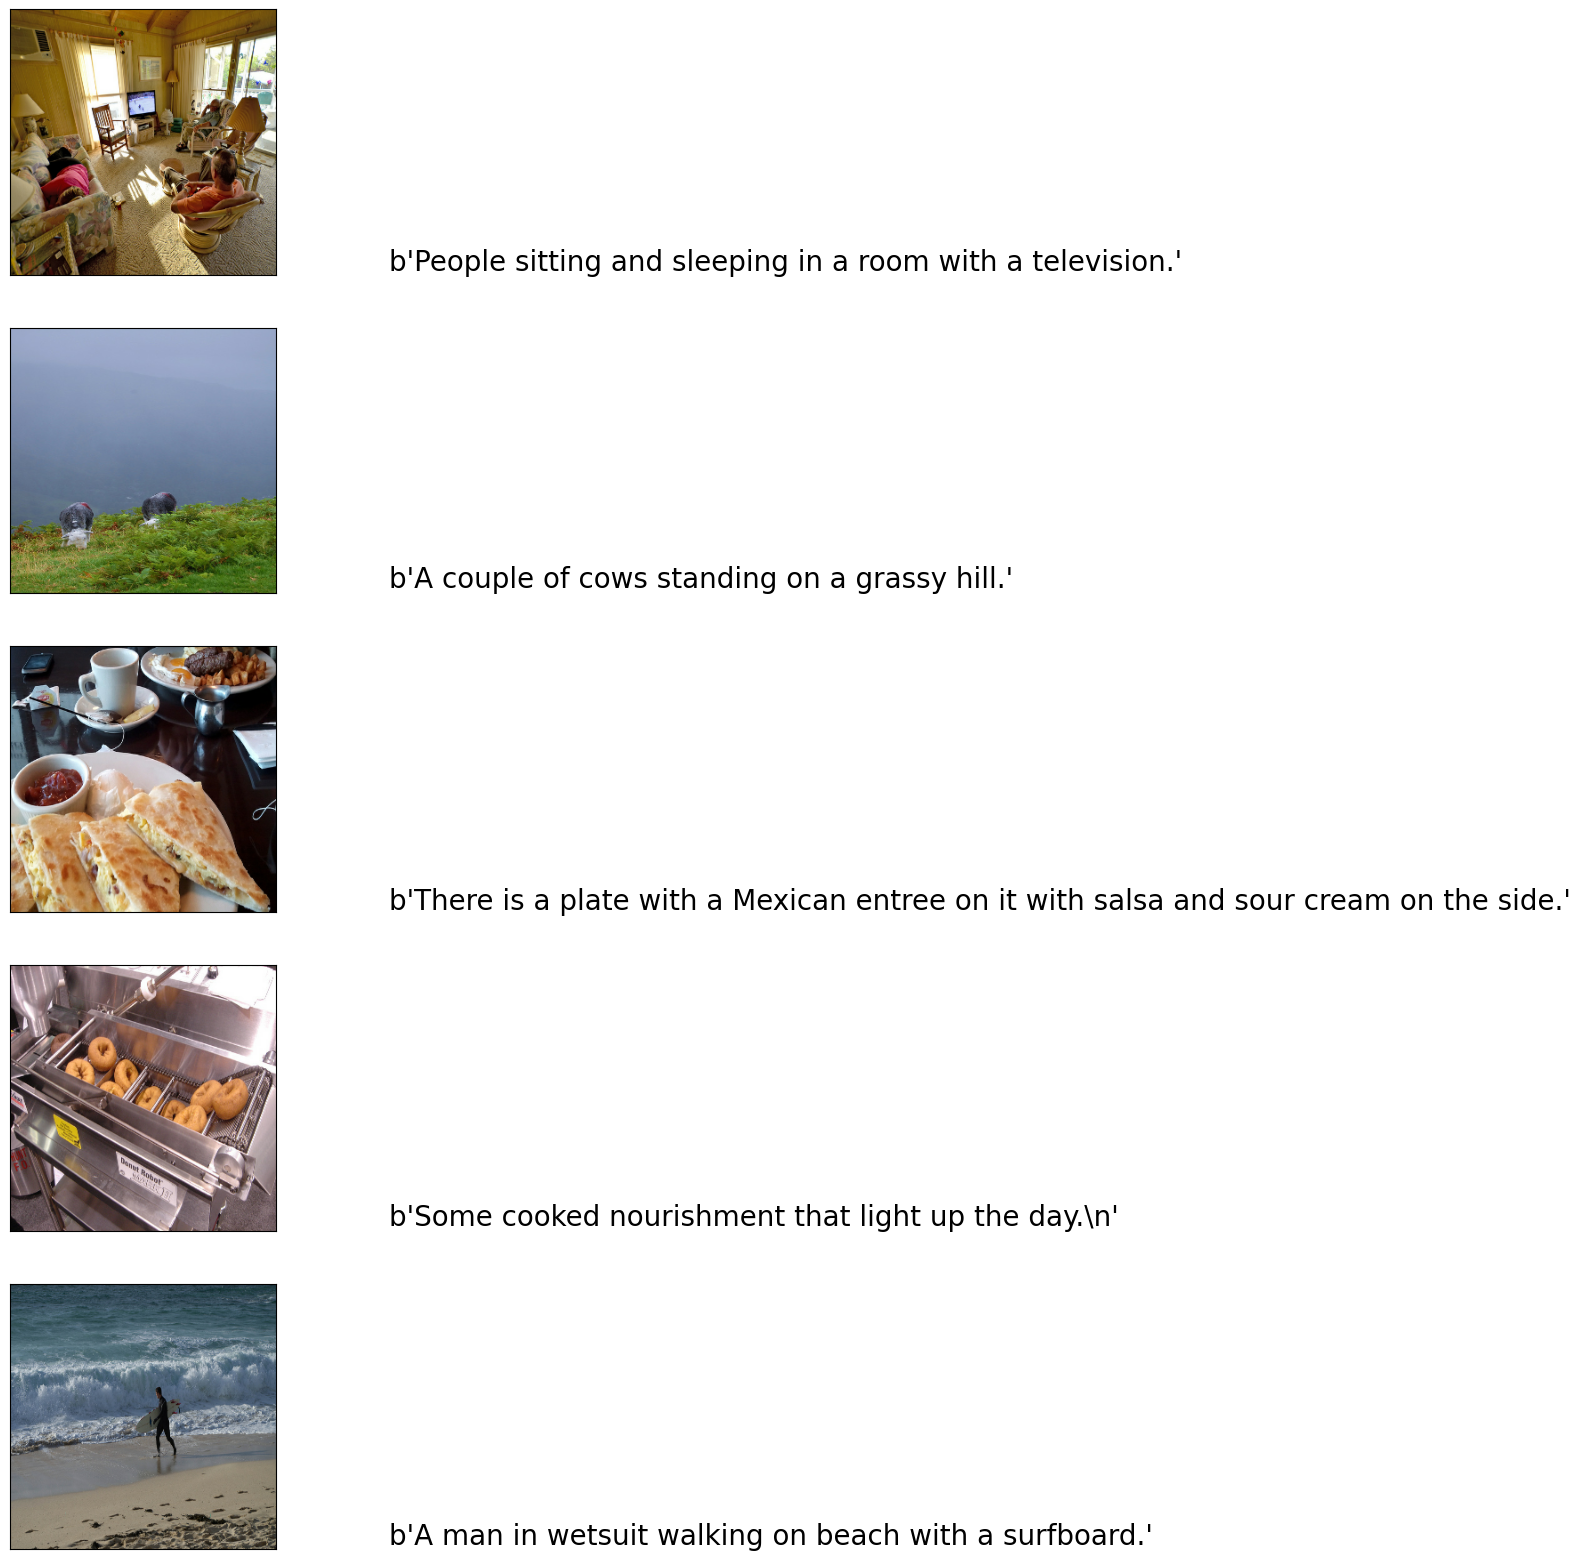

In [22]:
npic = 5 # Displaying 5 images from the dataset

count = 1
fig = plt.figure(figsize=(10,20))
for record in trainds.take(npic):
  caption = record["caption"]
  image = record["image_tensor"]
  ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
  ax.imshow(image)
  count += 1

  ax = fig.add_subplot(npic, 2, count)
  plt.axis(False)
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(caption.numpy()))
  # for i, caption in enumerate(caption):
  ax.text(0, 1, caption.numpy(), fontsize=20)
  count += 1
plt.show()

### Text (Caption) Preprocessing

In the text preprocessing step, we introduce special tokens to signify the start (`<start>`) and end (`<end>`) of sentences. These tokens are essential for our encoder-decoder model: the `<start>` token initiates caption generation, while the `<end>` token marks its conclusion, allowing for variable-length captions.

After adding these tokens, we compile a complete list of captions for additional preprocessing.

In [23]:
def add_start_end_token(data):
  start = tf.convert_to_tensor("startseq")
  end = tf.convert_to_tensor("endseq")
  data["caption"] = tf.strings.join([start, data["caption"], end],
                                    separator=" ")
  return data

trainds = trainds.map(add_start_end_token)

### Preprocess and Tokenize the Captions

To transform the text captions into integer sequences using the `TextVectorization` layer, follow these steps:

1. Use the `adapt` method to iterate through all captions, splitting them into words and creating a vocabulary of the top `VOCAB_SIZE` words.
2. Tokenize all captions by mapping each word to its corresponding index in the vocabulary. All output sequences will be padded to a length of `MAX_CAPTION_LEN`. Here, we specify a value of 64, which is sufficient for this dataset. However, if you want to avoid truncating very long sentences, it's recommended to calculate this value by processing the entire dataset.

**Note:** This process takes approximately 5 minutes.

In [25]:
MAX_CAPTION_LEN = 65
VOCAB_SIZE = 10000

def standardize(caption):
  caption = tf.strings.lower(caption)
  return tf.strings.regex_replace(
      caption, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
  )

# Use textvectorization
tokenizer = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))
print("finished")

finished


In [26]:
for word_id in tokenizer(["startseq This is me from future colab using token endseq"])[0]:
  print(tokenizer.get_vocabulary()[word_id], end=" ")

startseq [UNK] is [UNK] [UNK] [UNK] [UNK] using [UNK] endseq                                                        

In [27]:
for i, data in enumerate(trainds.take(5)):
  caption = data["caption"]
  print(f"Sample Sentence {i}: {caption.numpy()}")
  print(f"Equivalent tokenized tensor {i}: {tokenizer(caption)}")

Sample Sentence 0: b'startseq A man leading and walking next to a horse driven wagon. endseq'
Equivalent tokenized tensor 0: [  3   2  11 163   9  15  19  16   2 173 197  78   4   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
Sample Sentence 1: b'startseq A white toilet sitting in a bathroom next to a TP roller. endseq'
Equivalent tokenized tensor 1: [  3   2  70  34  17   7   2  60  19  16   2  87 130   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
Sample Sentence 2: b'startseq A bed sitting in a room on top of a large red rug. endseq'
Equivalent tokenized tensor 2: [  3   2 230  17   7   2  18   5  22   6   2  25  41 129   4   0   0   0
   0   0   0   0   0   0 

In [28]:
print(f"Original sentence: {caption}")
print("Reconstructed sentence: ")
for word_id in tokenizer(caption).numpy():
  print(tokenizer.get_vocabulary()[word_id], end=" ")

Original sentence: b'startseq two people near a giraffe near many trees endseq'
Reconstructed sentence: 
startseq two people near a giraffe near many trees endseq                                                        

### Create a LookUp For Vocabulary
To convert tokens into word and vice-versa

In [30]:
# string lookup word to id
word_to_idx = keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)
# word_id to string
idx_to_word = keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

### Create `tf.data` Dataset for Training

- Apply adapted tokenization to all examples to create a `tf.data` dataset for training.
  
- Generate labels by shifting the captions:
  - Example: For input `<start> I love cats <end>`, the label becomes `I love cats <end> <padding>`.
  - This helps the model learn to predict the first word `I` from the `<start>` token.

- The dataset returns tuples:
  - **First Element**: Features (`image_tensor` and `caption`).
  - **Second Element**: Label (target).

- For caption prediction, shift the tensor left while maintaining the same target shape.

- Analogy: Predicting the next word based on the previous words.

In [31]:
BATCH_SIZE = 32

def create_ds_fn(data):
  image_tensor = data["image_tensor"]
  caption = tokenizer(data["caption"])

  # shift tensor right to left eg, [1, 2,3] => [2, 3]
  target = tf.roll(caption, -1, 0)
  zeros = tf.zeros([1], dtype=tf.int64)
  # mantain shape of target by adding zero element in last index
  target = tf.concat((target[:-1], zeros), axis=-1)
  return (image_tensor, caption), target

batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Model Design

Let’s design an image captioning model, which comprises an image encoder and a caption decoder.

### Image Encoder (Feature Extractor)

The image encoder is straightforward and follows these steps:

- **Feature Extraction**: Utilizes a pre-trained model to extract features. Here in our notebook, we employ the convolutional layers of `InceptionResNetV2`. which produces a vector of shape (Batch Size, 8, 8, 1536).
- **Reshaping**: The vector is reshaped to (Batch Size, 64, 1536).
- **Dimensional Reduction**: A Dense layer reduces the length to `ATTENTION_DIM`, resulting in (Batch Size, 64, ATTENTION_DIM).
- **Attention Mechanism**: This representation allows the Attention layer to focus on the image while predicting the next word.

We use the pre-trained `inception_resnet_v2` model for feature extraction.

#### References:
- [Inception-ResNet v2 - Paper With Code](https://paperswithcode.com/method/inception-resnet-v2)
- [Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/pdf/1602.07261v2)

In [35]:
# Feature Extractor (InceptionResNetV2)
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
FEATURES_SHAPE = (8, 8, 1536)
FEATURE_EXTRACTOR.trainable = False
ATTENTION_DIM = 512

image_input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = keras.layers.Reshape((FEATURES_SHAPE[0]*FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(image_features)
encoder_output = keras.layers.Dense(ATTENTION_DIM, activation="relu")(x)

In [37]:
encoder = tf.keras.Model(inputs=image_input,
                         outputs=encoder_output)
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 inception_resnet_v2 (Funct  (None, None, None, 1536)     5433673   ['input_6[0][0]']             
 ional)                                                   6                                       
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (4,)                         0         ['inception_resnet_v2[0][0]'] 
 mbda)                                                                                            
                                                                                              

In [42]:
word_input = tf.keras.layers.Input(shape=(MAX_CAPTION_LEN, ), name="words")
embed_x = tf.keras.layers.Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = tf.keras.layers.GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = tf.keras.layers.Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = tf.keras.layers.Add()([gru_output, context_vector])

layer_norm = tf.keras.layers.LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = tf.keras.layers.Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

decoder = tf.keras.Model(
    inputs=[word_input, encoder_output],
    outputs=decoder_output
)
decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 65)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 65, 512)              5120000   ['words[0][0]']               
                                                                                                  
 gru (GRU)                   [(None, 65, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                                  
 input_7 (InputLayer)        [(None, 64, 512)]            0         []                      

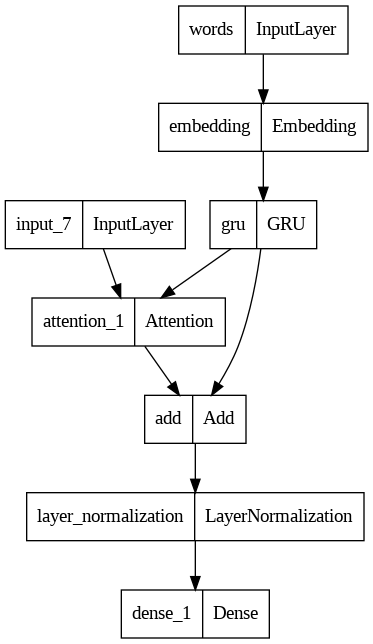

In [43]:
tf.keras.utils.plot_model(decoder)

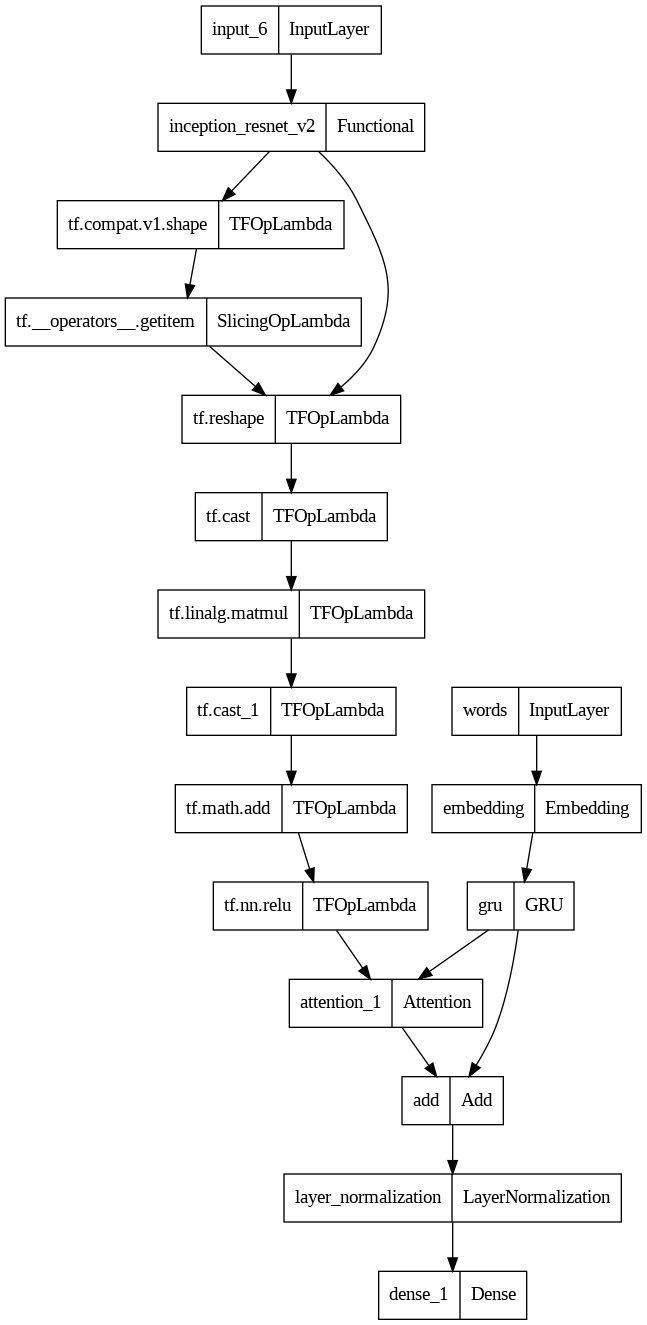

In [44]:
image_caption_training_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)
tf.keras.utils.plot_model(image_caption_training_model)

The loss function used here is a simple cross-entropy, but we must exclude padding (represented by 0) when calculating it. To do this, we first extract the length of the sentence (the non-zero part) and compute the average loss only over the valid portion of the sentence.

### Explanation of the Loss Function

- **Loss Module**: The `loss_module` is set up to compute sparse categorical cross-entropy. Using `from_logits=True` indicates that the predictions are raw logits, and `reduction="none"` ensures that we do not reduce the loss across the batch at this stage.

- **Mask Creation**: The mask identifies which elements of the `real` labels are not padding (0). It returns 1 for valid word indices and 0 for padding.

- **Sentence Length**: We compute the total length of the non-padding elements using `tf.reduce_sum(mask)`.

- **Filtering Loss**: We then filter the loss to include only the valid parts, up to `sentence_len`.

- **Mean Loss Calculation**: Finally, we compute and return the mean loss over the valid elements. This approach ensures that padding does not affect the overall loss calculation, providing a more accurate measure of model performance.

In [45]:
loss_module = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction="none")

def loss_function(real, pred):
    loss_ = loss_module(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [46]:
image_caption_training_model.compile(
    optimizer="adam",
    loss=loss_function
)

### Wall time vs CPU time
> CPU time - the time actually spent by CPU executing method code.

> Wall time - the real-world time elapsed between a pair of events, e.g. between method entry and method exit

In [47]:
# %%time
history = image_caption_training_model.fit(batched_ds, epochs=1)

1/1 [==============================] - 26s 26s/step - loss: 9.1640


## Caption Prediction

The prediction step differs from training because we need to maintain the GRU state during caption generation and provide the predicted word to the decoder as input for the next time step.

To achieve this, we will define a separate model for prediction that uses the trained weights, allowing it to keep and update the GRU state throughout the caption generation process.

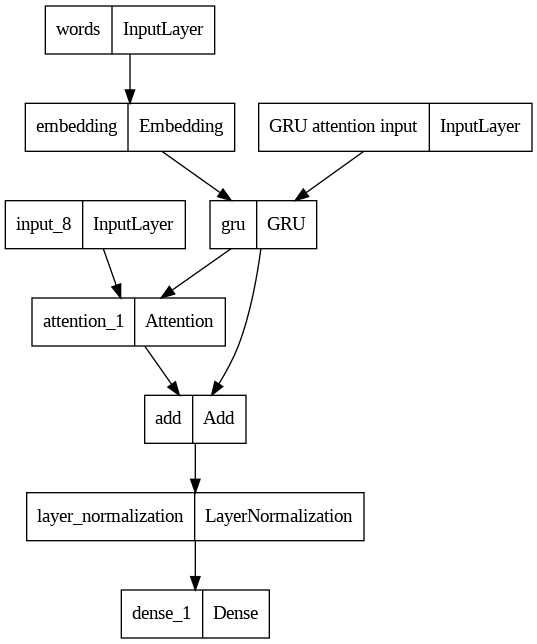

In [52]:
gru_state_input = tf.keras.layers.Input(
    shape=(ATTENTION_DIM, ),
    name="GRU attention input"
)
# reusing the trained gru but update to receive the state
gru_output, gru_state = decoder_gru(
    embed_x,
    initial_state=gru_state_input)

# reusing other layer
contex_vector=decoder_attention([gru_output, encoder_output])
addition_output = tf.keras.layers.Add()(
    [gru_output, contex_vector]
)
layer_norm_output = decoder_output_dense(addition_output)

# defining the prediction model
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state]
)
tf.keras.utils.plot_model(decoder_pred_model)

- Initialize the GRU states as zero vectors.
- Preprocess the input image, pass it to the encoder, and extract the image features.
- Set up the word token `<start>` to begin captioning.
  
- In the loop:
  - Pass the word token (`dec_input`), GRU states (`gru_state`), and image features (`features`) to the prediction decoder to obtain predictions and updated GRU states.
  - Select the top K words from the logits and choose one probabilistically, avoiding the need to compute softmax over the entire `VOCAB_SIZE`-.
  - Stop the prediction process when the model outputs the `<end>` token.
  - Replace the input word token with the predicted word token for the next step.

In [63]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
  gru_state = tf.zeros((1, ATTENTION_DIM))

  img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=N_CHANNELS)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255

  features = encoder(tf.expand_dims(img, axis=0))
  dec_input = tf.expand_dims([word_to_idx("<start>")], 1)
  result = []
  for i in range(MAX_CAPTION_LEN):
    predictions, gru_state = decoder_pred_model(
        [dec_input, gru_state, features]
    )

    # draws from log distribution given by predictions
    top_probs, top_idxs = tf.math.top_k(
        input=predictions[0][0], k=10, sorted=False
    )
    chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
    predicted_id = top_idxs.numpy()[chosen_id][0]

    print(result)
    print(predicted_id)
    result.append(tokenizer.get_vocabulary()[predicted_id])

    if predicted_id == word_to_idx("<end>"):
      return img, result

    dec_input = tf.expand_dims([predicted_id], 1)

  return img, result

### Generating Caption

In [55]:
!wget https://i.abcnewsfe.com/a/54508fa4-688e-4072-bbf0-67930d1d0336/baseball-1-ap-gmh-230901_1693579673197_hpMain_16x9.jpg -O baseball.jpeg

--2024-09-26 18:29:49--  https://i.abcnewsfe.com/a/54508fa4-688e-4072-bbf0-67930d1d0336/baseball-1-ap-gmh-230901_1693579673197_hpMain_16x9.jpg
Resolving i.abcnewsfe.com (i.abcnewsfe.com)... 23.210.215.105, 23.210.215.83, 2600:1417:e800::b81a:7f19, ...
Connecting to i.abcnewsfe.com (i.abcnewsfe.com)|23.210.215.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905641 (884K) [image/jpeg]
Saving to: ‘baseball.jpeg’

baseball.jpeg       100%[===================>] 884.42K   978KB/s    in 0.9s    

2024-09-26 18:29:53 (978 KB/s) - ‘baseball.jpeg’ saved [905641/905641]



In [64]:
filename = "/content/baseball.jpeg"

for i in range(5):
  image, caption = predict_caption(filename)
  print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=N_CHANNELS)
plt.imshow(img)
plt.axis("off");

[]
2568


IndexError: list index out of range